In [1]:
"""
Applicability Domain Expansion Analysis
Uses Isolation Forest to assess how augmentation expands the applicability domain
"""

import os
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from tqdm import tqdm
import pickle
from sklearn.ensemble import IsolationForest
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import json

warnings.filterwarnings('ignore')

# ============================================================================
# Feature Generation Functions
# ============================================================================

def generate_rdkit2d_features(smiles_list):
    """Generate RDKit 2D descriptors"""
    features = []
    valid_indices = []
    
    descriptor_names = [desc[0] for desc in Descriptors._descList]
    
    for idx, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            desc_values = []
            for desc_name in descriptor_names:
                desc_func = getattr(Descriptors, desc_name)
                try:
                    value = desc_func(mol)
                    desc_values.append(value if not np.isnan(value) else 0)
                except:
                    desc_values.append(0)
            features.append(desc_values)
            valid_indices.append(idx)
    
    return np.array(features), valid_indices

def generate_ecfp6_features(smiles_list, radius=3, n_bits=2048):
    """Generate ECFP6 (Morgan) fingerprints with radius 3"""
    features = []
    valid_indices = []
    
    for idx, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
            features.append(np.array(fp))
            valid_indices.append(idx)
    
    return np.array(features), valid_indices

# ============================================================================
# Isolation Forest Training
# ============================================================================

def train_applicability_domain_models(
    augmented_data_dir='../data/augment_all',
    output_dir='../data/applicabilityDomain',
    random_seed=42
):
    """
    Train Isolation Forest models for applicability domain assessment
    
    For each dataset:
    - Train on non-augmented only (baseline AD)
    - Train on augmented + non-augmented (expanded AD)
    - Use both rdkit2d and ecfp6 descriptors
    
    Parameters:
    -----------
    augmented_data_dir : str
        Directory containing augmented datasets
    output_dir : str
        Directory to save trained models and metadata
    random_seed : int
        Random seed for reproducibility
    """
    
    # Create output directories
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    models_dir = Path(output_dir) / 'models'
    models_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all augmented dataset files
    dataset_files = sorted(Path(augmented_data_dir).glob('*_augmented.parquet'))
    
    print(f"Found {len(dataset_files)} augmented datasets")
    print("="*80)
    
    # Storage for model metadata
    model_metadata = {}
    
    # Descriptor types
    descriptor_types = ['rdkit2d', 'ecfp6']
    
    # Training strategies
    training_strategies = ['non_aug_only', 'aug_plus_non_aug']
    
    # Process each dataset
    for dataset_file in dataset_files:
        dataset_name = dataset_file.stem.replace('_augmented', '')
        
        print(f"\n{'='*80}")
        print(f"Processing: {dataset_name}")
        print(f"{'='*80}")
        
        # Load augmented dataset
        df = pd.read_parquet(dataset_file)
        
        print(f"Total compounds: {len(df)}")
        
        # Separate augmented and non-augmented
        df_non_aug = df[df['AUG'] == False].copy()
        df_full = df.copy()
        
        print(f"Non-augmented: {len(df_non_aug)}")
        print(f"Augmented: {len(df[df['AUG'] == True])}")
        
        # Store metadata for this dataset
        model_metadata[dataset_name] = {
            'n_total': len(df),
            'n_non_aug': len(df_non_aug),
            'n_aug': len(df[df['AUG'] == True]),
            'models': {}
        }
        
        # For each descriptor type
        for descriptor_type in descriptor_types:
            print(f"\n--- Descriptor: {descriptor_type} ---")
            
            # Generate features for non-augmented
            print("Generating features for non-augmented data...")
            if descriptor_type == 'rdkit2d':
                X_non_aug, valid_non_aug = generate_rdkit2d_features(
                    df_non_aug['SMILES'].tolist()
                )
            elif descriptor_type == 'ecfp6':
                X_non_aug, valid_non_aug = generate_ecfp6_features(
                    df_non_aug['SMILES'].tolist()
                )
            
            print(f"  Valid features: {len(X_non_aug)}/{len(df_non_aug)}")
            
            # Generate features for full dataset
            print("Generating features for full augmented data...")
            if descriptor_type == 'rdkit2d':
                X_full, valid_full = generate_rdkit2d_features(
                    df_full['SMILES'].tolist()
                )
            elif descriptor_type == 'ecfp6':
                X_full, valid_full = generate_ecfp6_features(
                    df_full['SMILES'].tolist()
                )
            
            print(f"  Valid features: {len(X_full)}/{len(df_full)}")
            
            # Train Isolation Forest on non-augmented only
            print("\nTraining Isolation Forest on NON-AUGMENTED data...")
            model_non_aug = IsolationForest(
                contamination='auto',
                random_state=random_seed,
                n_jobs=-1
            )
            model_non_aug.fit(X_non_aug)
            
            # Save model
            model_name_non_aug = f'{dataset_name}_non_aug_only_{descriptor_type}.pkl'
            model_path_non_aug = models_dir / model_name_non_aug
            
            with open(model_path_non_aug, 'wb') as f:
                pickle.dump(model_non_aug, f)
            
            print(f"  ✓ Model saved: {model_name_non_aug}")
            
            # Store metadata
            model_metadata[dataset_name]['models'][f'non_aug_only_{descriptor_type}'] = {
                'filename': model_name_non_aug,
                'n_training_samples': len(X_non_aug),
                'n_features': X_non_aug.shape[1],
                'descriptor': descriptor_type,
                'training_strategy': 'non_aug_only'
            }
            
            # Train Isolation Forest on full dataset
            print("\nTraining Isolation Forest on AUGMENTED + NON-AUGMENTED data...")
            model_full = IsolationForest(
                contamination='auto',
                random_state=random_seed,
                n_jobs=-1
            )
            model_full.fit(X_full)
            
            # Save model
            model_name_full = f'{dataset_name}_aug_plus_non_aug_{descriptor_type}.pkl'
            model_path_full = models_dir / model_name_full
            
            with open(model_path_full, 'wb') as f:
                pickle.dump(model_full, f)
            
            print(f"  ✓ Model saved: {model_name_full}")
            
            # Store metadata
            model_metadata[dataset_name]['models'][f'aug_plus_non_aug_{descriptor_type}'] = {
                'filename': model_name_full,
                'n_training_samples': len(X_full),
                'n_features': X_full.shape[1],
                'descriptor': descriptor_type,
                'training_strategy': 'aug_plus_non_aug'
            }
    
    # Save metadata
    metadata_path = Path(output_dir) / 'model_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(model_metadata, f, indent=2)
    
    print(f"\n{'='*80}")
    print("All models trained successfully!")
    print(f"{'='*80}")
    print(f"Models saved in: {models_dir}")
    print(f"Metadata saved: {metadata_path}")
    print(f"\nTotal models trained: {sum(len(v['models']) for v in model_metadata.values())}")
    
    return model_metadata

# ============================================================================
# Screening Function
# ============================================================================

class ApplicabilityDomainScreener:
    """
    Class for screening compounds against trained Isolation Forest models
    """
    
    def __init__(self, models_dir='../data/applicabilityDomain/models'):
        """
        Initialize screener by loading all trained models
        
        Parameters:
        -----------
        models_dir : str
            Directory containing trained model files
        """
        self.models_dir = Path(models_dir)
        self.models = {}
        
        # Load all models
        model_files = sorted(self.models_dir.glob('*.pkl'))
        
        print(f"Loading models from: {models_dir}")
        print(f"Found {len(model_files)} model files")
        
        for model_file in model_files:
            model_name = model_file.stem
            with open(model_file, 'rb') as f:
                self.models[model_name] = pickle.load(f)
            
        print(f"✓ Loaded {len(self.models)} models")
    
    def screen_compounds(
        self,
        smiles_list,
        output_path=None
    ):
        """
        Screen a list of compounds against all trained models
        
        Parameters:
        -----------
        smiles_list : list
            List of SMILES strings to screen
        output_path : str, optional
            Path to save results (CSV or parquet)
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with SMILES and anomaly scores from each model
        """
        
        print(f"\n{'='*80}")
        print(f"Screening {len(smiles_list)} compounds")
        print(f"{'='*80}")
        
        # Initialize results dataframe
        results_df = pd.DataFrame({'SMILES': smiles_list})
        
        # Group models by descriptor type for efficient feature generation
        models_by_descriptor = {}
        for model_name in self.models.keys():
            if 'rdkit2d' in model_name:
                descriptor = 'rdkit2d'
            elif 'ecfp6' in model_name:
                descriptor = 'ecfp6'
            else:
                continue
            
            if descriptor not in models_by_descriptor:
                models_by_descriptor[descriptor] = []
            models_by_descriptor[descriptor].append(model_name)
        
        # Process each descriptor type
        for descriptor, model_names in models_by_descriptor.items():
            print(f"\n--- Processing descriptor: {descriptor} ---")
            
            # Generate features once per descriptor type
            print(f"Generating features for {len(smiles_list)} compounds...")
            if descriptor == 'rdkit2d':
                X, valid_indices = generate_rdkit2d_features(smiles_list)
            elif descriptor == 'ecfp6':
                X, valid_indices = generate_ecfp6_features(smiles_list)
            
            print(f"  Valid features: {len(X)}/{len(smiles_list)}")
            
            # Apply each model
            for model_name in model_names:
                print(f"  Applying model: {model_name}...")
                
                model = self.models[model_name]
                
                # Initialize column with NaN
                col_name = f'score_{model_name}'
                results_df[col_name] = np.nan
                
                # Compute anomaly scores for valid samples
                scores = model.score_samples(X)
                
                # Assign scores to valid indices
                for i, idx in enumerate(valid_indices):
                    results_df.loc[idx, col_name] = scores[i]
        
        print(f"\n✓ Screening complete!")
        print(f"  Result columns: {len(results_df.columns)}")
        print(f"  Score columns: {len([c for c in results_df.columns if c.startswith('score_')])}")
        
        # Save results if path provided
        if output_path:
            if str(output_path).endswith('.parquet'):
                results_df.to_parquet(output_path, index=False)
            else:
                results_df.to_csv(output_path, index=False)
            print(f"  ✓ Results saved to: {output_path}")
        
        return results_df
    
    def get_available_models(self):
        """Return list of available model names"""
        return list(self.models.keys())
    
    def get_model_info(self):
        """Print information about loaded models"""
        print(f"\n{'='*80}")
        print("LOADED MODELS")
        print(f"{'='*80}")
        
        # Group by dataset
        datasets = {}
        for model_name in sorted(self.models.keys()):
            # Extract dataset name (everything before the first underscore group)
            parts = model_name.split('_')
            
            # Find where 'non' or 'aug' starts
            dataset_parts = []
            for i, part in enumerate(parts):
                if part in ['non', 'aug']:
                    break
                dataset_parts.append(part)
            
            dataset = '_'.join(dataset_parts)
            
            if dataset not in datasets:
                datasets[dataset] = []
            datasets[dataset].append(model_name)
        
        print(f"\nTotal datasets: {len(datasets)}")
        print(f"Total models: {len(self.models)}")
        
        print(f"\n{'Dataset':<30} {'Models':<10}")
        print("-" * 80)
        
        for dataset, model_list in sorted(datasets.items()):
            print(f"{dataset:<30} {len(model_list):<10}")

# ============================================================================
# Convenience Functions
# ============================================================================

def quick_screen(smiles_list, models_dir='../data/applicabilityDomain/models'):
    """
    Quick screening function that loads models and screens compounds
    
    Parameters:
    -----------
    smiles_list : list
        List of SMILES strings
    models_dir : str
        Directory containing trained models
        
    Returns:
    --------
    pd.DataFrame
        Results with anomaly scores
    """
    screener = ApplicabilityDomainScreener(models_dir=models_dir)
    results = screener.screen_compounds(smiles_list)
    return results

def screen_from_file(
    input_file,
    smiles_column='SMILES',
    output_file=None,
    models_dir='../data/applicabilityDomain/models'
):
    """
    Screen compounds from a file
    
    Parameters:
    -----------
    input_file : str
        Path to input file (CSV or parquet)
    smiles_column : str
        Name of SMILES column
    output_file : str, optional
        Path to save results
    models_dir : str
        Directory containing trained models
        
    Returns:
    --------
    pd.DataFrame
        Results with anomaly scores
    """
    # Load input file
    if input_file.endswith('.parquet'):
        df = pd.read_parquet(input_file)
    else:
        df = pd.read_csv(input_file)
    
    smiles_list = df[smiles_column].tolist()
    
    # Screen
    screener = ApplicabilityDomainScreener(models_dir=models_dir)
    results = screener.screen_compounds(smiles_list, output_path=output_file)
    
    return results



In [2]:
print("="*80)
print("APPLICABILITY DOMAIN EXPANSION ANALYSIS")
print("="*80)
# Train all models
print("\nTraining Isolation Forest models...")
model_metadata = train_applicability_domain_models(
    augmented_data_dir='../data/augment_all',
    output_dir='../data/applicabilityDomain',
    random_seed=42
)


APPLICABILITY DOMAIN EXPANSION ANALYSIS

Training Isolation Forest models...
Found 1 augmented datasets

Processing: Cell Proliferation (IC50)
Total compounds: 431
Non-augmented: 243
Augmented: 188

--- Descriptor: rdkit2d ---
Generating features for non-augmented data...


[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerator
[12:31:46] DEPRECATION WARNING: please use MorganGenerat

  Valid features: 243/243
Generating features for full augmented data...


[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerator
[12:31:57] DEPRECATION WARNING: please use MorganGenerat

  Valid features: 431/431

Training Isolation Forest on NON-AUGMENTED data...
  ✓ Model saved: Cell Proliferation (IC50)_non_aug_only_rdkit2d.pkl

Training Isolation Forest on AUGMENTED + NON-AUGMENTED data...
  ✓ Model saved: Cell Proliferation (IC50)_aug_plus_non_aug_rdkit2d.pkl

--- Descriptor: ecfp6 ---
Generating features for non-augmented data...


[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerator
[12:32:15] DEPRECATION WARNING: please use MorganGenerat

  Valid features: 243/243
Generating features for full augmented data...


[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerator
[12:32:16] DEPRECATION WARNING: please use MorganGenerat

  Valid features: 431/431

Training Isolation Forest on NON-AUGMENTED data...
  ✓ Model saved: Cell Proliferation (IC50)_non_aug_only_ecfp6.pkl

Training Isolation Forest on AUGMENTED + NON-AUGMENTED data...
  ✓ Model saved: Cell Proliferation (IC50)_aug_plus_non_aug_ecfp6.pkl

All models trained successfully!
Models saved in: ../data/applicabilityDomain/models
Metadata saved: ../data/applicabilityDomain/model_metadata.json

Total models trained: 4


In [ ]:
# Example: Screen some test compounds
print("\n" + "="*80)
print("EXAMPLE SCREENING")
print("="*80)
# Load one of the original datasets for testing
test_data_path = Path('../data/exp')
test_files = list(test_data_path.glob('*.parquet'))
if test_files:
    print("\nLoading test compounds from first dataset...")
    test_df = pd.read_parquet(test_files[0])
    
    # Take first 10 compounds as example
    test_smiles = test_df['SMILES'].head(1000).tolist()
    
    print(f"Testing with {len(test_smiles)} compounds")
    
    # Screen
    screener = ApplicabilityDomainScreener(
        models_dir='../data/applicabilityDomain/models'
    )
    
    # Get model info
    screener.get_model_info()
    
    # Screen compounds
    results = screener.screen_compounds(
        test_smiles,
        output_path='../data/applicabilityDomain/example_screening.csv'
    )
    
    print("\nExample results (first 5 rows):")
    print(results.head())
    
    # Show score statistics
    score_cols = [c for c in results.columns if c.startswith('score_')]
    if score_cols:
        print("\nScore statistics:")
        print(results[score_cols].describe())
print("\n" + "="*80)
print("APPLICABILITY DOMAIN ANALYSIS COMPLETE!")
print("="*80)
print("\nTo screen new compounds, use:")
print("  from applicability_domain import quick_screen")
print("  results = quick_screen(['CC(=O)O', 'c1ccccc1', ...])")
print("\nOr screen from file:")
print("  from applicability_domain import screen_from_file")
print("  results = screen_from_file('compounds.csv', output_file='results.csv')")

In [10]:
results

,SMILES,score_Cell Proliferation (IC50)_aug_plus_non_aug_ecfp6,score_Cell Proliferation (IC50)_non_aug_only_ecfp6,score_Cell Proliferation (IC50)_aug_plus_non_aug_rdkit2d,score_Cell Proliferation (IC50)_non_aug_only_rdkit2d
0,CC(NC(=O)C(Cc1ccccc1)CP(O)(=O)C([NH3+])Cc1cccc...,-0.363355,-0.352267,-0.492741,-0.478702
1,COc1ccc2cc(C(=O)NCCc3ccc(N)cc3)c(=O)[nH]c2c1OCCCC,-0.362922,-0.355861,-0.499006,-0.475285
2,NC(=O)c1[n][n](CC(=O)N2C(CC3CC23)C(=O)NCC2CC2(...,-0.377975,-0.375953,-0.609567,-0.614253
3,CN(C)c1[n]c2c(cc(c(=O)[n]2C)-c2c(Cl)cccc2Cl)c[n]1,-0.351156,-0.359211,-0.495747,-0.472223
4,Cc1o[n]cc1C(=O)Nc1cc(F)c(cc1)-[n]1[n]c(cc1C1CC...,-0.348128,-0.351090,-0.489092,-0.474472
...,...,...,...,...,...
995,CC1CN(CC(Cc2ccccc2)C(=O)NC(CC2CCCCC2)C(O)=O)CC...,-0.360740,-0.368290,-0.592490,-0.562291
996,CC(c1ccc(cc1)C(F)(F)F)[n]1[n]c(CO)c2c(=O)[nH]c...,-0.376897,-0.366275,-0.570441,-0.537218
997,COc1ccc(cc1N1CCNCC1)N(S(=O)(=O)c1cccc2c1cccc2N...,-0.351492,-0.357337,-0.605921,-0.602350
998,O=S(=O)(c1ccc(F)cc1)C1(CCCC1)c1ccc(cc1)C(OCc1c...,-0.369056,-0.363276,-0.644111,-0.603351


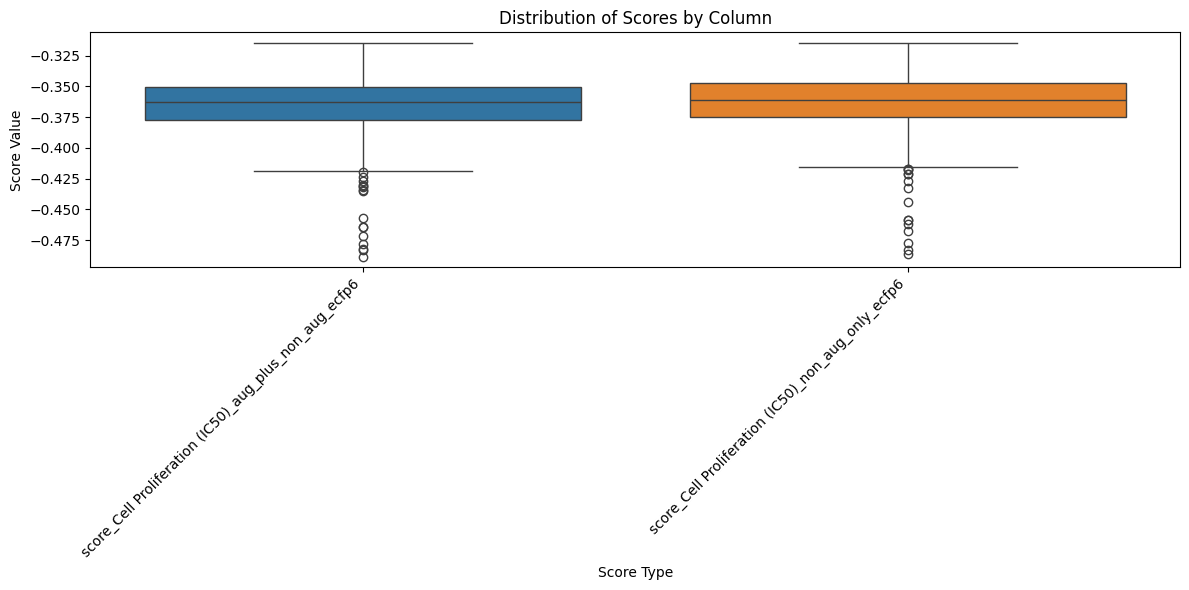

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Select only the score columns (excluding SMILES)
score_columns = [col for col in results.columns if col.startswith('score_')][:2]

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results[score_columns])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.xlabel('Score Type')
plt.ylabel('Score Value')
plt.title('Distribution of Scores by Column')
plt.tight_layout()
plt.show()